In [1]:
import torch
print(torch.__version__)

2.5.0+cu121


In [2]:
!pip install torch==2.2.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 746.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
import torch
print(torch.__version__)

2.2.1+cu121


In [2]:
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.2.1+cu121.html

Looking in links: https://data.pyg.org/whl/torch-2.2.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 37.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 46.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 943.4/943.4 kB 20.5 MB/s eta 0:00:00


In [3]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.5 MB/s eta 0:00:00


In [4]:
from sklearn.cluster import SpectralClustering

In [5]:
spectral_clustering_model = SpectralClustering(n_clusters=7)

In [6]:
import torch
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.nn.functional import dropout
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv, Linear, SAGEConv

In [7]:
data = Planetoid('data', 'Cora')

Processing...
Done!


In [9]:
dataset = data[0]

In [10]:
class GCN(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.conv1 = GCNConv(-1, 64)  # SAGEConv((-1, -1), 64)
        self.conv2 = GCNConv(-1, 128)  # SAGEConv((-1, -1), 128)

        self.linear1 = Linear(128, 64)
        self.linear2 = Linear(64, num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).tanh()
        x = dropout(x, p=0.3)

        x = self.conv2(x, edge_index).tanh()
        x = dropout(x, p=0.3)

        x = self.linear1(x)
        x = self.linear2(x)

        return x

In [11]:
def train(model, dataset, optimizer, criterion, epochs=5):
    if len(dataset.train_mask.shape) > 1:
        train_mask = dataset.train_mask[:, 0]
    else:
        train_mask = dataset.train_mask

    for epoch in range(epochs):
        model.eval()
        optimizer.zero_grad()
        out = model(dataset.x, dataset.edge_index)
        loss = criterion(out[train_mask],
                         dataset.y[train_mask])
        loss.backward()
        optimizer.step()

        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

In [12]:
gcn_model = GCN(num_classes=7)

In [13]:
train(model=gcn_model, dataset=dataset,
      optimizer=Adam(gcn_model.parameters(), lr=0.001),
      criterion=CrossEntropyLoss(), epochs=50)

Epoch: 000, Loss: 1.9529
Epoch: 001, Loss: 1.9395
Epoch: 002, Loss: 1.9236
Epoch: 003, Loss: 1.9110
Epoch: 004, Loss: 1.8979
Epoch: 005, Loss: 1.8804
Epoch: 006, Loss: 1.8520
Epoch: 007, Loss: 1.8317
Epoch: 008, Loss: 1.8079
Epoch: 009, Loss: 1.7793
Epoch: 010, Loss: 1.7435
Epoch: 011, Loss: 1.7069
Epoch: 012, Loss: 1.6709
Epoch: 013, Loss: 1.6249
Epoch: 014, Loss: 1.5858
Epoch: 015, Loss: 1.5321
Epoch: 016, Loss: 1.4803
Epoch: 017, Loss: 1.4076
Epoch: 018, Loss: 1.3551
Epoch: 019, Loss: 1.2839
Epoch: 020, Loss: 1.2133
Epoch: 021, Loss: 1.1451
Epoch: 022, Loss: 1.0750
Epoch: 023, Loss: 0.9966
Epoch: 024, Loss: 0.9284
Epoch: 025, Loss: 0.8582
Epoch: 026, Loss: 0.7990
Epoch: 027, Loss: 0.7323
Epoch: 028, Loss: 0.6540
Epoch: 029, Loss: 0.5946
Epoch: 030, Loss: 0.5422
Epoch: 031, Loss: 0.4795
Epoch: 032, Loss: 0.4440
Epoch: 033, Loss: 0.3910
Epoch: 034, Loss: 0.3536
Epoch: 035, Loss: 0.3196
Epoch: 036, Loss: 0.2705
Epoch: 037, Loss: 0.2512
Epoch: 038, Loss: 0.2188
Epoch: 039, Loss: 0.1873


In [17]:
gcn_embeddings = gcn_model.conv1(dataset.x, dataset.edge_index).detach().cpu().numpy()

In [18]:
gcn_embeddings

array([[-0.13328388, -0.03008513, -0.24483135, ...,  0.1005897 ,
         0.31218836, -0.15465751],
       [-0.6148425 , -0.34961018,  0.5458719 , ..., -0.5889596 ,
        -0.55620414, -0.22650707],
       [-0.50863266, -0.19168097,  0.2344453 , ..., -0.2946223 ,
        -0.2628454 , -0.20900993],
       ...,
       [ 0.10363199,  0.09629031, -0.04137741, ...,  0.1476564 ,
        -0.10414516, -0.16957235],
       [-0.17865872, -0.25695297, -0.08923559, ...,  0.12466615,
         0.16912271, -0.24905531],
       [-0.14551625, -0.22879662, -0.19074139, ...,  0.15965044,
         0.19648437, -0.25168294]], dtype=float32)

In [19]:
from sklearn.cluster import KMeans

In [20]:
kmeans_model = KMeans(n_clusters=7)

In [21]:
kmeans_model.fit(gcn_embeddings)

KMeans(n_clusters=7)

In [22]:
kmeans_model.labels_

array([3, 1, 1, ..., 0, 3, 3], dtype=int32)

In [23]:
from sklearn.manifold import TSNE

In [24]:
model_tsne = TSNE(n_components=2)

In [25]:
gcn_embeddings_2d = model_tsne.fit_transform(gcn_embeddings)

In [26]:
import matplotlib.pyplot as plt

In [27]:
labels = dataset.y.detach().cpu().numpy()

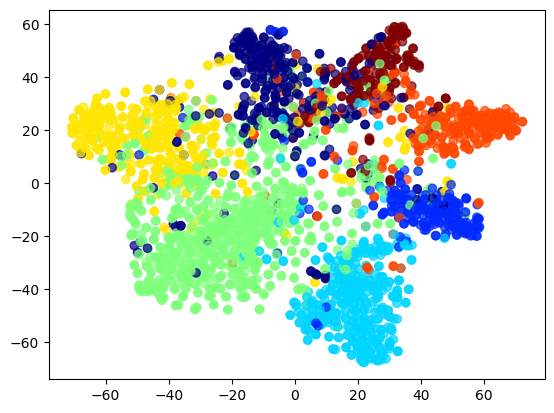

In [28]:
plt.scatter(gcn_embeddings_2d[:, 0], gcn_embeddings_2d[:, 1],
            c=labels, cmap='jet', alpha=0.7)

In [31]:
predicted_clusters = kmeans_model.labels_

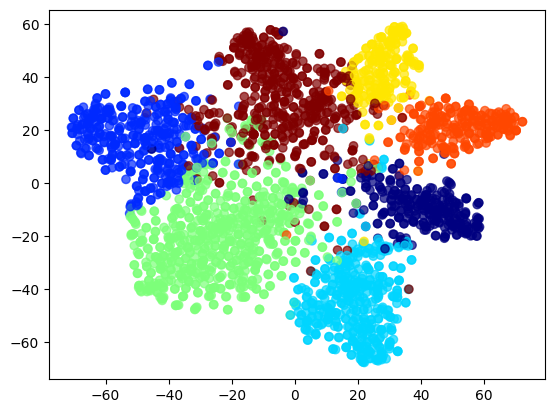

In [32]:
plt.scatter(gcn_embeddings_2d[:, 0], gcn_embeddings_2d[:, 1],
            c=predicted_clusters, cmap='jet', alpha=0.7)